In [2]:
import json
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [3]:
# Define directories and hyperparameters
train_dir = 'D:/testproject/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train'
val_dir = 'D:/testproject/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid'
test_dir = 'D:/testproject/New Plant Diseases Dataset(Augmented)/test'
img_size = (299, 299)  # Input size for InceptionV3
batch_size = 16
epochs = 20
patience = 5

In [4]:
# Data preprocessing and augmentation
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 12750 images belonging to 17 classes.
Found 7809 images belonging to 17 classes.
Found 468 images belonging to 1 classes.


In [5]:
# Load InceptionV3 model with pre-trained weights
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

# Freeze all layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top of the base model
model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(train_generator.num_classes, activation='softmax')
])

In [6]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [7]:
# Define callbacks
checkpoint = ModelCheckpoint('models/inception_plant_disease_detection[17032024].h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_loss', patience=patience, verbose=1, restore_best_weights=True)

In [8]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,
    callbacks=[checkpoint, early_stopping]
) 

Epoch 1/20
796/796 [==============================] - ETA: 0s - loss: 1.8247 - accuracy: 0.4050
Epoch 1: val_accuracy improved from -inf to 0.80853, saving model to models\inception_plant_disease_detection[17032024].h5
796/796 [==============================] - 390s 473ms/step - loss: 1.8247 - accuracy: 0.4050 - val_loss: 0.7305 - val_accuracy: 0.8085
Epoch 2/20
796/796 [==============================] - ETA: 0s - loss: 1.3165 - accuracy: 0.5404
Epoch 2: val_accuracy improved from 0.80853 to 0.81519, saving model to models\inception_plant_disease_detection[17032024].h5
796/796 [==============================] - 327s 410ms/step - loss: 1.3165 - accuracy: 0.5404 - val_loss: 0.6462 - val_accuracy: 0.8152
Epoch 3/20
796/796 [==============================] - ETA: 0s - loss: 1.1651 - accuracy: 0.5829
Epoch 3: val_accuracy improved from 0.81519 to 0.83799, saving model to models\inception_plant_disease_detection[17032024].h5
796/796 [==============================] - 273s 343ms/step - loss: 

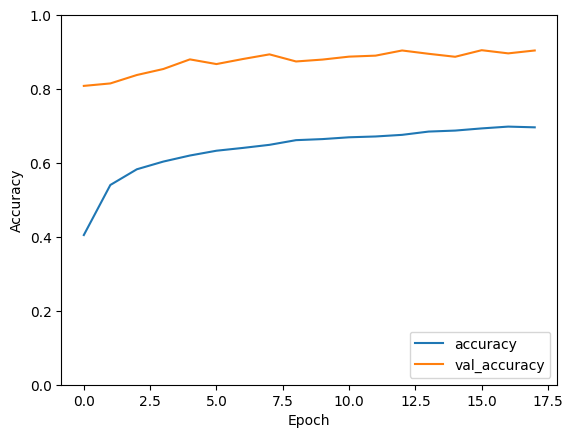

In [9]:
# Plot training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

In [10]:
# Evaluate the model on test generator
test_loss, test_accuracy = model.evaluate_generator(test_generator, verbose=1)
print('Test Accuracy:', test_accuracy)
print('Test Loss:', test_loss)

C:\Users\Nabu\AppData\Local\Temp\ipykernel_1600\1344913736.py:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  test_loss, test_accuracy = model.evaluate_generator(test_generator, verbose=1)


30/30 [==============================] - 6s 192ms/step - loss: 287.1122 - accuracy: 0.0449
Test Accuracy: 0.044871795922517776
Test Loss: 287.1121520996094


In [11]:
# Create a mapping from class indices to class names
class_indices = {v: k for k, v in train_generator.class_indices.items()}

In [12]:
# Save class indices to a JSON file
with open('class_indices_inception.json', 'w') as f:
    json.dump(class_indices, f)


In [13]:
# Load class indices
with open('class_indices_xception.json', 'r') as f:
    class_indices = json.load(f)

# Load remedies
with open('remedies.json', 'r') as f:
    remedies= json.load(f)

In [14]:
# Function to predict disease from an image
def predict_disease(image_path):
    # Load and preprocess the image
    img = load_img(image_path, target_size=(img_size))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    # Make prediction
    prediction = model.predict(img_array)[0]
    predicted_class_index = np.argmax(prediction)
    disease = class_indices[str(predicted_class_index)]
    confidence = prediction[predicted_class_index]

    return disease, confidence 

In [15]:
# Path to your test image
image_path = 'New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid/Corn_(maize)___Northern_Leaf_Blight/0b4fb93e-1a74-42ae-9227-18d900c04bd7___RS_NLB 3670.JPG'  # Replace with your image path

# Predict disease for the test image
disease, confidence = predict_disease(image_path)

print(f'Predicted Disease: {disease}, Confidence: {confidence}')
# Display remedies for the predicted disease
if disease.strip() in remedies:
    remedy = remedies[disease]
    print(f'Remedies: {remedy}')
else:
    print('No remedies found for this disease.')


1/1 [==============================] - 3s 3s/step
Predicted Disease: Corn_(maize)___Northern_Leaf_Blight, Confidence: 0.9989274144172668
Remedies: Remedies for Corn Northern Leaf Blight
